In [1]:
from u import *
from model import Transformer
from data import SequentialIterator
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

%load_ext autoreload
%autoreload 2
vocab = (Cache / 'sorted_vocab.npy').load()

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
def get_stats(name):
    c = Config(Res / name).load()
    net = Transformer(c)
    net, step = c.init_model(net, step=c.get('step', 'max'), train=False)
    cache_search_path = c.res / ('cache_step%s_n%s.yaml' % (step, c.get('n_cache')))
    if cache_search_path.exists():
        for k in 'cache_theta_init', 'cache_lambda_init':
            if c.get(k):
                c.unvar(k)
        params = cache_search_path.load()
        c.var(**params)
        print('Loaded cache search parameters')
        print(params)
    data = SequentialIterator(c, c.eval_batch, split='valid')

    net.loss.cache_keys = net.loss.cache_values = None
    c.loss_no_mean = True
    c.keep_order = True
    net.eval()
    token_losses = defaultdict(list)
    losses = []
    lasts = {}
    token_offsets = defaultdict(list)
    offset_losses = defaultdict(list)
    with torch.no_grad():
        prevs = None
        i = 1
        for batch in data:
            x = to_torch(batch, c.device).t()
            inputs, labels = x[:-1], x[1:]

            preds = net.forward(inputs, labels, prevs=prevs)
            for token, loss in zip(*from_torch((labels.reshape(-1), preds['loss'].reshape(-1)))):
                if token in lasts:
                    token_offsets[token].append(i - lasts[token])
                    offset_losses[i - lasts[token]].append(loss)
                lasts[token] = i
                token_losses[token].append(loss)
                losses.append(loss)
                i += 1
            prevs = preds['state']
    print(name, np.e ** np.mean(losses))
    return Namespace(losses=np.array(losses), t_losses=token_losses, t_offsets=token_offsets, o_losses=offset_losses)

In [3]:
stats = {}
for name in '8.3M_cache0_hebbian', '8.3M_cache1000_hebbian', '8.3M_cache2000_hebbian':
    stats[name] = get_stats(name)
stat2000 = stats['8.3M_cache2000_hebbian']
stat1000 = stats['8.3M_cache1000_hebbian']
stat0 = stats['8.3M_cache0_hebbian']

8.3M_cache0_hebbian 39.23129774761762
Loaded cache search parameters
{'cache_lambda': 0.11514829239315753, 'cache_theta': 0.025465622469125388, 'n_cache': 1000, 'use_cache': True}
8.3M_cache1000_hebbian 34.0539325219024
Loaded cache search parameters
{'cache_lambda': 0.14506585896015167, 'cache_theta': 0.026574067771434784, 'n_cache': 2000, 'use_cache': True}
8.3M_cache2000_hebbian 33.003787380592314


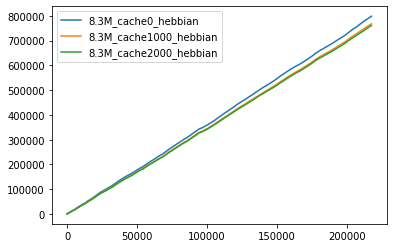

In [4]:
for k, v in stats.items():
    v.t_sum_loss = np.array([np.sum(v.t_losses.get(i, [])) for i in range(len(vocab))])
    v.t_mean_loss = np.array([np.mean(v.t_losses.get(i, [])) for i in range(len(vocab))])
    v.o_sum_loss = np.array([np.sum(v.o_losses.get(i, [])) for i in range(max(v.o_losses.keys()) + 1)])
    v.o_n = np.array([len(v.o_losses.get(i, [])) for i in range(max(v.o_losses.keys()) + 1)])
for k, v in stats.items():
    plt.plot(np.cumsum(v.losses), label=k)
plt.legend()
plt.show()

In [5]:
val = (Cache / 'wikitext-103/sorted_valid.npy').load()
text = np.array([vocab[x] for x in val])
counts = np.zeros(vocab.shape)
for x in val:
    counts[x] += 1
    
for eos, x in enumerate(vocab):
    if x == '<eos>': break
for eq, x in enumerate(vocab):
    if x == '=': break
        
article_starts = []
for i, (t, t1, t2) in enumerate(zip(val, val[1:], val[2:])):
    if t == eos and t1 == eq and t2 != eq:
        article_starts.append(i)

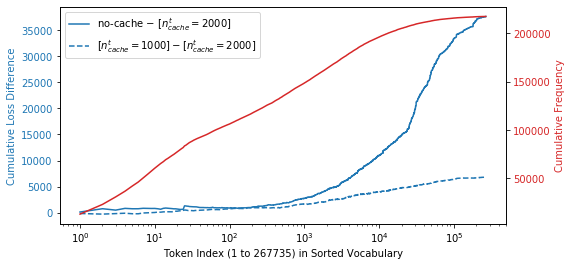

In [6]:
import matplotlib
plt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots(figsize=(8, 4))
xs = 1 + np.arange(len(vocab))
ax1.plot(xs, np.cumsum(stat0.t_sum_loss - stat2000.t_sum_loss), color=plt_colors[0], label='no-cache $-\ [n_{cache}^t = 2000]$')
ax1.plot(xs, np.cumsum(stat1000.t_sum_loss - stat2000.t_sum_loss), color=plt_colors[0], linestyle='--', label='$[n_{cache}^t = 1000] - [n_{cache}^t = 2000]$')
ax1.set_ylabel('Cumulative Loss Difference', color=plt_colors[0])
ax1.tick_params(axis='y', labelcolor=plt_colors[0])
ax1.set_xscale('log')
ax1.set_xlabel('Token Index (1 to 267735) in Sorted Vocabulary')
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Frequency', color=plt_colors[3])
ax2.plot(xs, np.cumsum(counts), color=plt_colors[3])
ax2.tick_params(axis='y', labelcolor=plt_colors[3])

plt.savefig('token_loss.svg')
plt.show()

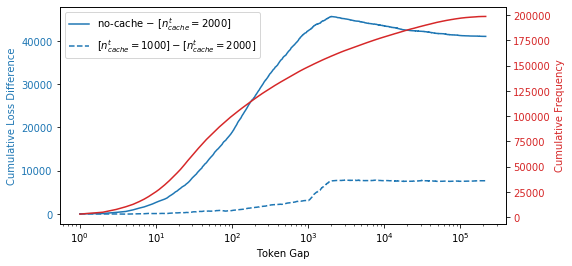

In [7]:
fig, ax1 = plt.subplots(figsize=(8, 4))
xs = np.arange(1, len(stat0.o_sum_loss))
ax1.plot(xs, np.cumsum(stat0.o_sum_loss - stat2000.o_sum_loss)[1:], color=plt_colors[0], label='no-cache $ -\ [n_{cache}^t = 2000]$')
ax1.plot(xs, np.cumsum(stat1000.o_sum_loss - stat2000.o_sum_loss)[1:], color=plt_colors[0], linestyle='--', label='$[n_{cache}^t = 1000] - [n_{cache}^t = 2000]$')
ax1.set_ylabel('Cumulative Loss Difference', color=plt_colors[0])
ax1.tick_params(axis='y', labelcolor=plt_colors[0])
ax1.set_xscale('log')
ax1.set_xlabel('Token Gap')
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Frequency', color=plt_colors[3])
ax2.plot(xs, np.cumsum(stat0.o_n)[1:], color=plt_colors[3])
ax2.tick_params(axis='y', labelcolor=plt_colors[3])

plt.savefig('gap_loss.svg')
plt.show()